In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from PIL import Image
import os
import cv2

from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, concatenate, Input, Flatten, Dense
from tensorflow.keras import Model

import warnings
warnings.filterwarnings("ignore")

In [3]:
train = pd.read_csv('train_32000.csv', )
train = train.drop(['Unnamed: 0'], axis=1)
train.head(5)

,image,center_hip_x,center_hip_y,left_hip_x,left_hip_y,left_knee_x,left_knee_y,left_ankle_x,left_ankle_y,left_bigtoe_X,...,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,right_ear_y
0,./K-pop 안무 영상/Training/[원천]100 (슈퍼엠)/083_I00_0...,177.3225,88.245,184.4820,88.5780,183.6495,115.551,184.4820,138.8610,183.4830,...,177.489,39.96,179.4870,37.9620,175.1580,38.1285,183.3165,40.959,171.4950,41.2920
1,./K-pop 안무 영상/Training/[원천]100 (슈퍼엠)/083_I00_0...,176.8230,87.912,184.3155,87.9120,183.6495,115.551,184.1490,140.6925,183.4830,...,177.489,39.96,179.8200,37.9620,175.1580,38.2950,183.3165,40.959,171.9945,41.2920
2,./K-pop 안무 영상/Training/[원천]100 (슈퍼엠)/083_I00_0...,177.8220,88.578,183.9825,88.4115,183.6495,115.551,184.1490,141.1920,183.3165,...,177.489,39.96,179.6535,38.1285,174.9915,38.1285,183.3165,40.959,171.9945,41.4585
3,./K-pop 안무 영상/Training/[원천]100 (슈퍼엠)/083_I00_0...,177.8220,88.578,184.6485,88.5780,183.6495,115.551,184.1490,140.1930,183.3165,...,177.489,39.96,179.4870,38.1285,174.9915,38.2950,183.3165,40.959,171.8280,41.2920
4,./K-pop 안무 영상/Training/[원천]100 (슈퍼엠)/083_I00_0...,177.8220,88.578,183.9825,88.5780,183.6495,115.551,183.6495,139.6935,183.6495,...,177.489,39.96,179.8200,38.1285,174.9915,38.4615,183.3165,40.959,172.1610,41.2920


In [4]:
train_paths = list(train['image'])

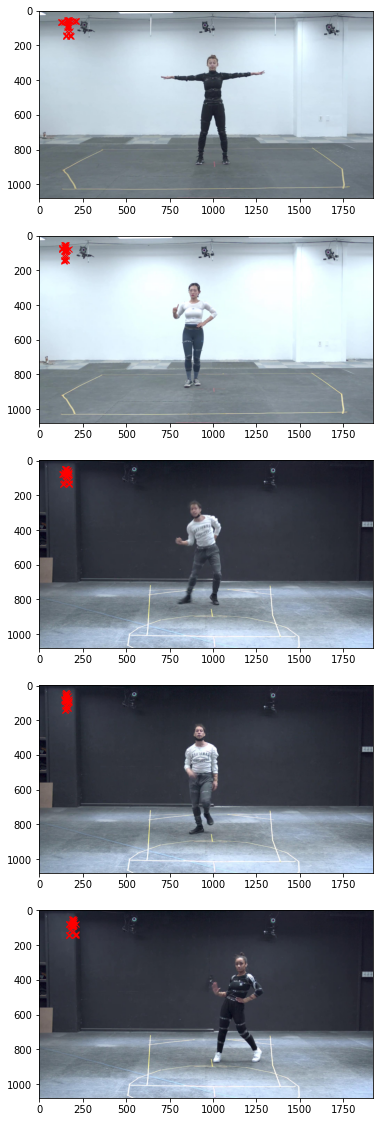

In [5]:
plt.figure(figsize=(40,20))
count=1

for i in np.random.randint(0,len(train_paths),5):
    
    plt.subplot(5,1, count)
    
    img_sample_path = train_paths[i]
    img = Image.open(img_sample_path)
    img_np = np.array(img)

    keypoint = train.iloc[:,1:59] #위치키포인트 하나씩 확인
    keypoint_sample = keypoint.iloc[i, :]
    
    for j in range(0,len(keypoint.columns),2):
        plt.plot(keypoint_sample[j], keypoint_sample[j+1],'rx')
        plt.imshow(img_np)
    
    count += 1

In [6]:
def trainGenerator():
    for i in range(len(train)):
        img = tf.io.read_file(train['image'][i]) # path(경로)를 통해 이미지 읽기
        img = tf.image.decode_jpeg(img, channels=3) # 경로를 통해 불러온 이미지를 tensor로 변환
        img = tf.image.resize(img, [180,320]) # 이미지 resize 
        img = img/255                         # 이미지 rescaling
        target = train.iloc[:,1:59].iloc[i,:] # keypoint 뽑아주기
        
        yield (img, target)


#generator를 활용해 데이터셋 만들기        
train_dataset = tf.data.Dataset.from_generator(trainGenerator, (tf.float32, tf.float32), (tf.TensorShape([180,320,3]),tf.TensorShape([58])))
train_dataset = train_dataset.batch(32).prefetch(1)

In [7]:
from tensorflow.python.keras.layers.advanced_activations import LeakyReLU
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.python.keras.layers import Activation, Convolution2D, MaxPooling2D, Flatten, Dense, Dropout, Conv2D,MaxPool2D, ZeroPadding2D

In [8]:
#간단한 CNN 모델을 적용합니다.

model = Sequential()

model.add(Convolution2D(32, (3,3), padding='same', use_bias=False, input_shape=(180,320,3)))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(32, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(64, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(64, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(96, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(96, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))


model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(58))

In [9]:
model.compile(optimizer='adam', 
              loss='mean_squared_error',
              metrics=['mae'])

In [10]:
model.fit(train_dataset,epochs = 20, verbose=1)

Epoch 1/20
1000/1000 [==============================] - 6883s 7s/step - loss: 438.8297 - mae: 15.2409
Epoch 2/20
1000/1000 [==============================] - 7196s 7s/step - loss: 357.0475 - mae: 13.9196
Epoch 3/20
1000/1000 [==============================] - 6903s 7s/step - loss: 296.7091 - mae: 12.0671
Epoch 4/20
1000/1000 [==============================] - 6912s 7s/step - loss: 211.2759 - mae: 10.7617
Epoch 5/20
1000/1000 [==============================] - 6983s 7s/step - loss: 198.9794 - mae: 10.4640
Epoch 6/20
1000/1000 [==============================] - 6897s 7s/step - loss: 178.9635 - mae: 9.8810
Epoch 7/20
1000/1000 [==============================] - 6948s 7s/step - loss: 173.7269 - mae: 9.7774
Epoch 8/20
1000/1000 [==============================] - 6960s 7s/step - loss: 159.3180 - mae: 9.4188
Epoch 9/20
1000/1000 [==============================] - 6960s 7s/step - loss: 146.3474 - mae: 9.0050
Epoch 10/20
1000/1000 [==============================] - 6652s 7s/step - loss: 145.820

In [11]:
from keras.models import load_model

model.save('data_32000_epoch_20')  # creates a HDF5 file 'my_model.h5'

INFO:tensorflow:Assets written to: data_32000_epoch_20\assets


In [40]:
test = pd.read_csv('original_test.csv', )
test = test.drop(['Unnamed: 0'], axis=1)
test = test[:200]
test

,image,center_hip_x,center_hip_y,left_hip_x,left_hip_y,left_knee_x,left_knee_y,left_ankle_x,left_ankle_y,left_bigtoe_X,...,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,right_ear_y
0,./K-pop 안무 영상/Validation/[원천]Psycho (레드벨벳)/099...,916,560,964,558,940,771,930,926,918,...,923,241,939,222,904,223,966,237,877,234
1,./K-pop 안무 영상/Validation/[원천]Psycho (레드벨벳)/099...,916,560,964,560,940,771,930,926,918,...,923,241,939,222,904,223,966,237,882,240
2,./K-pop 안무 영상/Validation/[원천]Psycho (레드벨벳)/099...,916,560,964,560,940,777,930,921,918,...,923,241,939,222,904,223,966,237,882,240
3,./K-pop 안무 영상/Validation/[원천]Psycho (레드벨벳)/099...,916,560,964,560,940,777,930,921,918,...,923,241,939,222,904,223,966,237,882,240
4,./K-pop 안무 영상/Validation/[원천]Psycho (레드벨벳)/099...,916,560,964,560,940,777,930,921,918,...,923,241,939,222,904,223,966,237,882,240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,./K-pop 안무 영상/Validation/[원천]Psycho (레드벨벳)/099...,920,560,970,559,938,770,929,933,912,...,934,257,953,236,920,234,974,239,887,236
196,./K-pop 안무 영상/Validation/[원천]Psycho (레드벨벳)/099...,920,561,965,559,938,773,928,936,914,...,934,254,952,236,920,235,975,242,886,235
197,./K-pop 안무 영상/Validation/[원천]Psycho (레드벨벳)/099...,914,565,968,558,938,770,930,934,913,...,936,258,952,240,919,235,974,242,888,236
198,./K-pop 안무 영상/Validation/[원천]Psycho (레드벨벳)/099...,920,561,971,559,938,770,929,941,913,...,931,255,952,236,919,235,973,240,886,235


In [41]:
test_paths = test['image']

In [42]:
X_test=[]

for test_path in tqdm(test_paths):
    img=tf.io.read_file(test_path)
    img=tf.image.decode_jpeg(img, channels=3)
    img=tf.image.resize(img, [180,320])
    img = img/255                  
    X_test.append(img)

100%|██████████| 200/200 [00:03<00:00, 66.09it/s]


In [43]:
X_test=tf.stack(X_test, axis=0)
X_test.shape

TensorShape([200, 180, 320, 3])

In [44]:
pred=model.predict(X_test)

In [55]:
predict = pd.DataFrame(pred, columns = ["center_hip_x", "center_hip_y", "left_hip_x", "left_hip_y", "left_knee_x", "left_knee_y", "left_ankle_x", "left_ankle_y", "left_bigtoe_X", "left_bigtoe_y",
                "left_littletoe_x", "left_littletoe_y", "right_hip_x", "right_hip_y", "right_knee_x", "right_knee_y", "right_ankle_x", "right_ankle_y", "right_bigtoe_x", "right_bigtoe_y",
                "right_littletoe_x", "right_littletoe_y", "navel_x", "navel_y", "chest_x", "chest_y", "neck_x", "neck_y", "left_shoulder_x", "left_shoulder_y", "left_elbow_x", "left_elbow_y",
                "left_wrist_x", "left_wrist_y", "left_palm_thumb_x", "left_palm_thumb_y", "left_palm_pinky_x", "left_palm_pinky_y", "right_shoulder_x", "right_shoulder_y", "right_elbow_x", "right_elbow_y",
                "right_wrist_x", "right_wrist_y", "right_palm_thumb_x", "right_palm_thumb_y", "right_palm_pinky_x", "right_palm_pinky_y", "nose_x", "nose_y", "left_eye_x", "left_eye_y",
                "right_eye_x", "right_eye_y", "left_ear_x", "left_ear_y", "right_ear_x", "right_ear_y"])

predict

,center_hip_x,center_hip_y,left_hip_x,left_hip_y,left_knee_x,left_knee_y,left_ankle_x,left_ankle_y,left_bigtoe_X,left_bigtoe_y,...,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,right_ear_y
0,148.615768,73.703499,154.422760,73.553108,155.991547,100.026833,157.159698,131.146439,157.824875,141.968887,...,142.560486,34.969322,145.245346,33.067337,140.576263,32.932079,149.899750,34.480888,140.277802,34.474892
1,148.530777,73.564888,154.353851,73.414398,155.916046,99.943901,157.086243,131.118011,157.761551,141.963120,...,142.465698,34.782951,145.158264,32.881664,140.475189,32.747459,149.820038,34.303585,140.181473,34.301395
2,148.370468,73.606071,154.180313,73.456253,155.776871,99.943817,156.934433,131.035446,157.617905,141.859848,...,142.300903,34.878105,144.989578,32.978493,140.314606,32.843555,149.643158,34.395195,140.020874,34.392311
3,148.180817,73.542076,153.988892,73.393532,155.573380,99.855507,156.713608,130.917725,157.401337,141.734680,...,142.128601,34.835865,144.815842,32.937763,140.139313,32.803547,149.459290,34.353981,139.839752,34.353157
4,147.303574,74.364525,152.996719,74.236656,154.716095,100.341240,155.609818,130.758545,156.384033,141.555389,...,141.011200,35.825222,143.710403,33.937103,139.045822,33.799648,148.361084,35.322311,138.841095,35.333321
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,144.433243,78.873718,149.076233,78.678375,152.419937,102.396217,152.466415,127.888412,153.002914,137.109497,...,139.546173,42.867306,141.766159,41.107277,137.929474,40.832932,145.437424,42.363483,136.980209,42.042931
196,144.594025,78.992973,149.242615,78.799423,152.554535,102.537361,152.577698,128.065170,153.114975,137.315018,...,139.683167,42.917660,141.910782,41.155342,138.061569,40.881527,145.593414,42.414673,137.120880,42.096790
197,144.436264,79.054008,149.076904,78.861519,152.381729,102.539726,152.373856,127.998787,152.911362,137.232727,...,139.533249,43.029850,141.757858,41.268105,137.910645,40.994259,145.430878,42.521332,136.964523,42.203800
198,144.373978,78.940170,149.014420,78.746689,152.276550,102.458984,152.277725,127.954826,152.804764,137.204773,...,139.455704,42.885468,141.682907,41.124985,137.834442,40.851612,145.366730,42.384972,136.897659,42.068130


In [34]:
# 좌표값에 8곱하기
predict = predict * 8
predict

,center_hip_x,center_hip_y,left_hip_x,left_hip_y,left_knee_x,left_knee_y,left_ankle_x,left_ankle_y,left_bigtoe_X,left_bigtoe_y,...,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,right_ear_y
0,924.117493,529.614685,965.921753,533.742188,943.507507,694.783997,983.854614,799.907654,972.774475,857.249329,...,924.075439,264.837372,928.944824,253.696487,916.793457,254.973221,952.636963,270.912354,899.125244,266.967804
1,926.250000,530.595764,968.221741,534.732422,945.725342,696.205566,986.154175,801.564209,975.025146,859.042297,...,926.195923,265.200409,931.080444,254.046066,918.918335,255.333862,954.859009,271.309021,901.199524,267.360260
2,922.528748,528.768188,964.330261,532.888794,941.945984,693.764099,982.162048,798.798218,971.103821,856.065735,...,922.466675,264.340363,927.343201,253.221649,915.184631,254.498901,951.013489,270.419617,897.501221,266.498413
3,924.004028,529.535217,965.915588,533.660278,943.485901,694.722717,983.800171,799.878662,972.737122,857.241211,...,923.933044,264.701752,928.821716,253.573288,916.675659,254.874908,952.568604,270.800354,898.953003,266.907318
4,924.551392,528.287231,965.739624,532.396729,943.275940,692.528992,984.156067,796.796631,972.931213,853.902771,...,924.561829,264.463226,929.351685,253.346985,917.518372,254.627869,952.978882,270.459930,900.298035,266.416565
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,889.360352,539.152588,925.615295,542.836670,922.498840,687.111633,961.138000,788.128662,956.633118,841.183228,...,890.087585,289.730927,896.137085,278.481934,881.615479,279.373108,918.434814,293.644470,866.203369,290.577362
196,890.255127,539.442993,926.518555,543.127808,923.178955,687.575623,961.887451,788.662476,957.307190,841.785828,...,890.979919,289.759583,897.014526,278.498718,882.511658,279.389618,919.326904,293.682434,867.087769,290.596985
197,889.300659,539.325867,925.553162,543.003662,922.189270,687.277405,960.844543,788.324036,956.308777,841.431885,...,890.054321,289.777405,896.085327,278.512085,881.575012,279.405060,918.381348,293.685059,866.111938,290.619812
198,887.395813,538.508484,923.610168,542.177429,920.239563,686.036560,958.818909,786.835266,954.314819,839.846741,...,888.156250,289.466187,894.182373,278.218567,879.684814,279.112915,916.457397,293.364502,864.229370,290.314545


In [46]:
# 좌표값에 6곱하기
predict = predict * 6
predict

,center_hip_x,center_hip_y,left_hip_x,left_hip_y,left_knee_x,left_knee_y,left_ankle_x,left_ankle_y,left_bigtoe_X,left_bigtoe_y,...,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,right_ear_y
0,891.694580,442.221008,926.536560,441.318665,935.949280,600.161011,942.958191,786.878662,946.949219,851.813354,...,855.362915,209.815933,871.472046,198.404022,843.457581,197.592468,899.398499,206.885330,841.666809,206.849350
1,891.184692,441.389343,926.123108,440.486389,935.496277,599.663391,942.517456,786.708069,946.569336,851.778687,...,854.794189,208.697708,870.949585,197.289978,842.851135,196.484756,898.920227,205.821503,841.088867,205.808380
2,890.222778,441.636414,925.081909,440.737518,934.661255,599.662903,941.606567,786.212646,945.707397,851.159058,...,853.805420,209.268631,869.937500,197.870956,841.887634,197.061340,897.858948,206.371170,840.125244,206.353867
3,889.084900,441.252441,923.933350,440.361206,933.440308,599.133057,940.281616,785.506348,944.408020,850.408081,...,852.771606,209.015198,868.895020,197.626587,840.835876,196.821289,896.755737,206.123886,839.038513,206.118942
4,883.821411,446.187134,917.980347,445.419922,928.296570,602.047424,933.658936,784.551270,938.304199,849.332336,...,846.067200,214.951324,862.262451,203.622620,834.274902,202.797882,890.166504,211.933868,833.046570,211.999924
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,866.599487,473.242310,894.457397,472.070251,914.519653,614.377319,914.798462,767.330444,918.017456,822.656982,...,837.277039,257.203827,850.596924,246.643661,827.576843,244.997589,872.624512,254.180908,821.881226,252.257584
196,867.564148,473.957825,895.455688,472.796539,915.327209,615.224182,915.466187,768.390991,918.689819,823.890137,...,838.098999,257.505951,851.464722,246.932053,828.369385,245.289154,873.560486,254.488037,822.725281,252.580750
197,866.617554,474.324036,894.461426,473.169128,914.290405,615.238342,914.243164,767.992737,917.468140,823.396362,...,837.199463,258.179108,850.547119,247.608627,827.463867,245.965546,872.585266,255.127991,821.787109,253.222809
198,866.243896,473.641022,894.086548,472.480133,913.659302,614.753906,913.666382,767.728943,916.828613,823.228638,...,836.734253,257.312805,850.097412,246.749908,827.006653,245.109680,872.200378,254.309830,821.385986,252.408783


In [52]:
# 좌표값에 6곱하기
predict = predict * 6.5
predict

,center_hip_x,center_hip_y,left_hip_x,left_hip_y,left_knee_x,left_knee_y,left_ankle_x,left_ankle_y,left_bigtoe_X,left_bigtoe_y,...,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,right_ear_y
0,966.002502,479.072754,1003.747925,478.095215,1013.945068,650.174438,1021.538025,852.451843,1025.861694,922.797791,...,926.643188,227.300598,944.094727,214.937683,913.745728,214.058517,974.348389,224.125778,911.805725,224.086792
1,965.450073,478.171783,1003.300049,477.193604,1013.454285,649.635376,1021.060547,852.267090,1025.450073,922.760254,...,926.027039,226.089188,943.528687,213.730820,913.088745,212.858490,973.830261,222.973297,911.179565,222.959076
2,964.408020,478.439453,1002.172058,477.465637,1012.549683,649.634827,1020.073792,851.730408,1024.516357,922.088989,...,924.955872,226.707687,942.432251,214.360199,912.044922,213.483109,972.680542,223.568771,910.135681,223.550018
3,963.175293,478.023499,1000.927795,477.057953,1011.226990,649.060791,1018.638428,850.965210,1023.108704,921.275391,...,923.835938,226.433121,941.302979,214.095459,910.905518,213.223053,971.485352,223.300873,908.958374,223.295517
4,957.473206,483.369415,994.478699,482.538269,1005.654602,652.218079,1011.463806,849.930542,1016.496216,920.110046,...,916.572815,232.863937,934.117615,220.591171,903.797852,219.697708,964.347046,229.595032,902.467102,229.666580
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,938.816101,512.679199,968.995483,511.409424,990.729614,665.575439,991.031677,831.274658,994.518921,891.211731,...,907.050110,278.637482,921.480042,267.197296,896.541565,265.414062,945.343262,275.362640,890.371338,273.279053
196,939.861145,513.454346,970.077026,512.196228,991.604492,666.492859,991.755005,832.423584,995.247314,892.547607,...,907.940552,278.964783,922.420105,267.509735,897.400208,265.729919,946.357178,275.695374,891.285706,273.629150
197,938.835693,513.851074,968.999878,512.599854,990.481262,666.508240,990.430054,831.992126,993.923828,892.012695,...,906.966125,279.694031,921.426086,268.242676,896.419189,266.462677,945.300720,276.388672,890.269409,274.324707
198,938.430847,513.111084,968.593750,511.853485,989.797607,665.983398,989.805237,831.706360,993.230957,891.831055,...,906.462097,278.755554,920.938904,267.312408,895.923889,265.535492,944.883728,275.502319,889.834778,273.442841


In [56]:
# 좌표값에 6.25곱하기
predict = predict * 6.25
predict

,center_hip_x,center_hip_y,left_hip_x,left_hip_y,left_knee_x,left_knee_y,left_ankle_x,left_ankle_y,left_bigtoe_X,left_bigtoe_y,...,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,right_ear_y
0,928.848572,460.646881,965.142273,459.706940,974.947144,625.167725,982.248108,819.665222,986.405457,887.305542,...,891.003052,218.558258,907.783386,206.670853,878.601624,205.825500,936.873413,215.505554,876.736267,215.468079
1,928.317383,459.780548,964.711548,458.839996,974.475281,624.649353,981.789001,819.487549,986.009705,887.269470,...,890.410645,217.393448,907.239136,205.510406,877.969910,204.671616,936.375244,214.397400,876.134216,214.383728
2,927.315430,460.037933,963.626953,459.101593,973.605469,624.648865,980.840210,818.971558,985.111877,886.624023,...,889.380615,217.988159,906.184875,206.115585,876.966309,205.272217,935.269714,214.969971,875.130493,214.951950
3,926.130127,459.637970,962.430542,458.709564,972.333618,624.096924,979.460022,818.235779,983.758362,885.841736,...,888.303772,217.724152,905.098999,205.861023,875.870728,205.022171,934.120544,214.712387,873.998474,214.707230
4,920.647339,464.778290,956.229492,463.979095,966.975586,627.132751,972.561340,817.240906,977.400208,884.721191,...,881.320007,223.907639,898.190002,212.106903,869.036377,211.247803,927.256775,220.764450,867.756836,220.833252
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,902.707764,492.960754,931.726440,491.739838,952.624634,639.976379,952.915100,799.302551,956.268188,856.934326,...,872.163574,267.920654,886.038513,256.920471,862.059204,255.205826,908.983887,264.771759,856.126282,262.768311
196,903.712646,493.706085,932.766357,492.496399,953.465820,640.858521,953.610596,800.407288,956.968567,858.218872,...,873.019775,268.235382,886.942383,257.220886,862.884827,255.509537,909.958862,265.091705,857.005493,263.104950
197,902.726624,494.087555,931.730652,492.884491,952.385803,640.873291,952.336609,799.992432,955.695984,857.704529,...,872.082825,268.936554,885.986633,257.925659,861.941528,256.214111,908.942993,265.758331,856.028259,263.773743
198,902.337341,493.376068,931.340149,492.166809,951.728455,640.368652,951.735779,799.717651,955.029785,857.529846,...,871.598145,268.034180,885.518188,257.031158,861.465271,255.322571,908.542053,264.906067,855.610352,262.925812


In [57]:
my_test = pd.concat([test['image'], predict], axis=1)

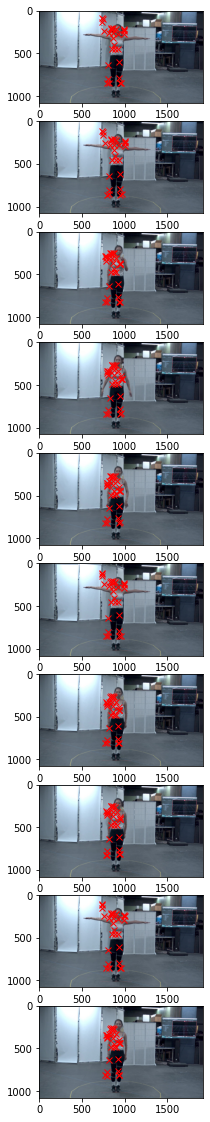

In [48]:
# 학습시킬 때 좌표값에 1/6했으니 테스할때 다시 6곱해준 것
# 테스트

plt.figure(figsize=(40,20))
count=1

for i in np.random.randint(0,len(test_paths),10):
    
    plt.subplot(10,1, count)
    
    img_sample_path = test_paths[i]
    img = Image.open(img_sample_path)
    img_np = np.array(img)

    keypoint = my_test.iloc[:,1:59] #위치키포인트 하나씩 확인
    keypoint_sample = keypoint.iloc[i, :]
    
    for j in range(0,len(keypoint.columns),2):
        plt.plot(keypoint_sample[j], keypoint_sample[j+1],'rx')
        plt.imshow(img_np)
    
    count+=1
    

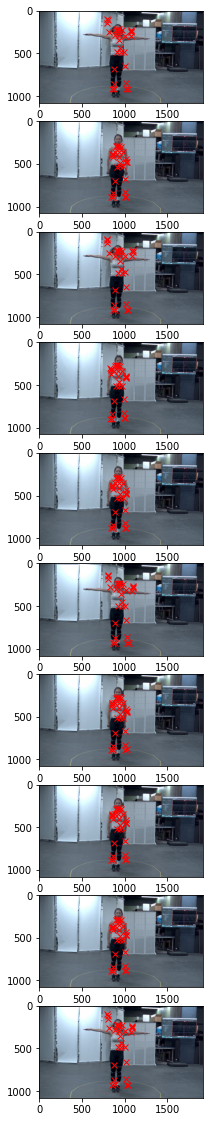

In [54]:
# 좌표갑에 6.5곱한것(그냥 추측성)
# 테스트

plt.figure(figsize=(40,20))
count=1

for i in np.random.randint(0,len(test_paths),10):
    
    plt.subplot(10,1, count)
    
    img_sample_path = test_paths[i]
    img = Image.open(img_sample_path)
    img_np = np.array(img)

    keypoint = my_test.iloc[:,1:59] #위치키포인트 하나씩 확인
    keypoint_sample = keypoint.iloc[i, :]
    
    for j in range(0,len(keypoint.columns),2):
        plt.plot(keypoint_sample[j], keypoint_sample[j+1],'rx')
        plt.imshow(img_np)
    
    count += 1

In [ ]:
# 좌표갑에 6.5곱한것(그냥 추측성)
# 테스트

plt.figure(figsize=(40,20))
count=1

for i in np.random.randint(0,len(test_paths),10):
    
    plt.subplot(10,1, count)
    
    img_sample_path = test_paths[i]
    img = Image.open(img_sample_path)
    img_np = np.array(img)

    keypoint = my_test.iloc[:,1:59] #위치키포인트 하나씩 확인
    keypoint_sample = keypoint.iloc[i, :]
    
    for j in range(0,len(keypoint.columns),2):
        plt.plot(keypoint_sample[j], keypoint_sample[j+1],'rx')
        plt.imshow(img_np)
    
    count += 1